In [47]:
def clean(path):
    raw_haemo = beer_lambert_law(short_channel_regression(optical_density(read_raw_snirf(path))))
    raw_haemo = raw_haemo.filter(None, 0.4,
                                h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                verbose=False)
    raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
    raw_haemo = enhance_negative_correlation(raw_haemo)
    # raw_haemo = short_channel_regression(raw_haemo)
    raw_haemo = temporal_derivative_distribution_repair(raw_haemo)

    return raw_haemo    

In [48]:
n_subs = 10
ch_names = ["Resp.", "PPG", "Sp02", "HR", "GSR", "Temp."]

Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\ses-01\nirs\sub-01_ses-01_task-wings_nirs.snirf
Reading 0 ... 5829  =      0.000 ...  1145.981 secs...
keys: <KeysViewHDF5 ['formatVersion', 'nirs']>


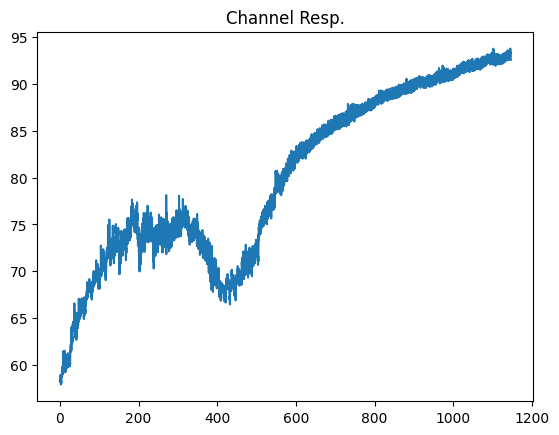

keys: <KeysViewHDF5 ['formatVersion', 'nirs']>


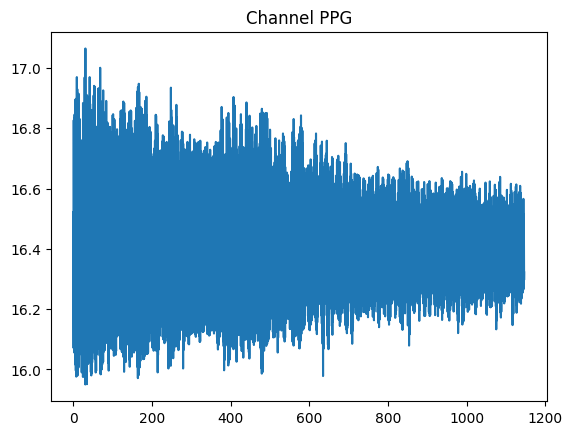

keys: <KeysViewHDF5 ['formatVersion', 'nirs']>


KeyboardInterrupt: 

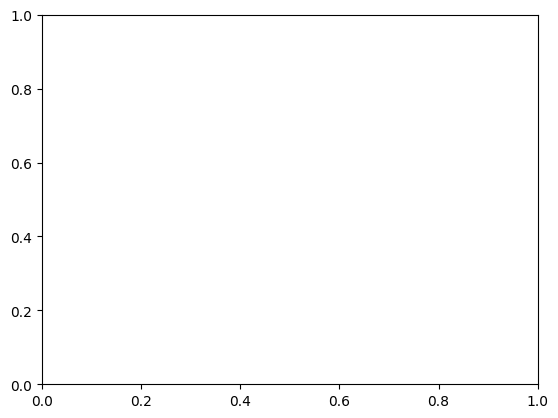

In [63]:
times = []
sub_frames = {}
lowest_idx = 10000
n_subs = 2

for sub in range(1,n_subs+1):                
    subject_id = "%02d" % sub
    raw_path = BIDSPath(
        subject="%02d" % sub,
        task='wings',
        session='01',
        datatype="nirs",
        suffix='nirs',
        root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
        extension=".snirf"
    )

    # create a df for each subject
    df_name = f'df_{sub}'
    sub_frames[sub] = pd.DataFrame()

    raw_haemo = clean(raw_path)

    for n in (range(18, 24)):
        ch = ch_names[n-18]
        with hf.File(raw_path, 'r') as f:

            aux = np.array(f.get(f'nirs/aux{n}/dataTimeSeries'))
            aux_time = np.array(f.get(f'nirs/aux{n}/time'))
            #print keys
            print(f'keys: {f.keys()}')

            start_time  = np.array(f.get(f'nirs//'))

        aux_data_interp = interpolate.interp1d(aux_time, aux, axis=0, bounds_error=False, fill_value='extrapolate')
        aux_data_match = aux_data_interp(raw_haemo.times)

        sub_frames[sub]['sub'] = sub
        sub_frames[sub]['time'] = raw_haemo.times
        sub_frames[sub][ch] = aux_data_match

        if sub_frames[sub]['time'].idxmax() < lowest_idx:
            lowest_idx = sub_frames[sub]['time'].idxmax()


    print(f'lowest_idx: {lowest_idx}')

In [50]:
# Define a resample function
def resample(df, lowest_idx):
    if lowest_idx >= len(df):
        return df  # If the DataFrame is smaller than lowest_idx, return the original DataFrame
    else:
        return df.sample(n=lowest_idx, random_state=42)

In [51]:
# Define a custom function to assign 'morning' or 'afternoon' based on subject
def assign_time_of_day(subject):
    if subject % 2 == 1:  # Odd subject
        return 'Morning'
    else:  # Even subject
        return 'Afternoon'

In [52]:
for sub in sub_frames:
    resampled_df = resample(sub_frames[sub], lowest_idx)
    resampled_df.sort_values(by=['time'], inplace=True)
    sub_frames[sub] = resampled_df
    sub_frames[sub].reset_index(drop=True, inplace=True)

    # Add a new column 'TimeOfDay' based on the 'sub' column
    sub_frames[sub]['Time of Day'] = sub_frames[sub]['sub'].apply(assign_time_of_day)
    sub_frames[sub].insert(1, 'Time of Day', sub_frames[sub].pop('Time of Day'))
    display(sub_frames[sub].head())
else:
    print(f"Subject {sub} not found in sub_frames.")


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,1,Morning,0.0000,58.297924,16.521999,99.0,54.0,0.019745,22.8125
1,1,Morning,0.1966,58.297924,16.521999,99.0,54.0,0.019745,22.8125
2,1,Morning,0.3932,58.501197,16.311001,99.0,54.0,0.019752,22.6875
3,1,Morning,0.5898,58.878977,16.160999,99.0,54.0,0.019753,22.6875
4,1,Morning,0.7864,58.891563,16.070999,99.0,54.0,0.019760,22.6875


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,2,Afternoon,0.0000,93.556358,16.379999,127.0,511.0,0.018893,24.4375
1,2,Afternoon,0.1966,93.556358,16.379999,127.0,511.0,0.018893,24.4375
2,2,Afternoon,0.3932,93.235413,16.386000,127.0,511.0,0.018885,24.4375
3,2,Afternoon,0.5898,92.868614,16.387665,127.0,511.0,0.018877,24.4375
4,2,Afternoon,0.9830,93.318329,16.381001,127.0,511.0,0.018869,24.4375


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,3,Morning,0.0000,-1.712177,16.004999,100.0,54.0,0.015661,22.0625
1,3,Morning,0.1966,14.062221,16.004999,100.0,54.0,0.015464,22.0625
2,3,Morning,0.3932,22.190679,15.985089,100.0,54.0,0.015278,22.0625
3,3,Morning,0.5898,20.978793,16.983000,100.0,54.0,0.015232,22.0625
4,3,Morning,0.7864,30.489952,16.622000,100.0,54.0,0.015836,22.1250


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,4,Afternoon,0.0000,93.923157,16.440001,100.0,54.0,0.016719,21.8750
1,4,Afternoon,0.1966,93.923157,16.440001,100.0,54.0,0.016719,21.8750
2,4,Afternoon,0.3932,93.969009,16.379000,100.0,54.0,0.016716,21.8750
3,4,Afternoon,0.5898,93.877312,16.319000,100.0,54.0,0.016716,21.8750
4,4,Afternoon,0.7864,93.815331,16.295000,100.0,54.0,0.016721,21.8125


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,5,Morning,0.0000,95.115250,16.152000,100.0,66.0,0.007840,22.6875
1,5,Morning,0.1966,95.115250,16.152000,100.0,66.0,0.008823,22.6875
2,5,Morning,0.3932,95.772238,16.539608,100.0,66.0,0.009014,22.7500
3,5,Morning,0.5898,95.915507,16.100783,100.0,66.0,0.008981,22.7500
4,5,Morning,0.7864,95.711296,16.486000,100.0,66.0,0.008945,22.7500


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,6,Afternoon,0.0000,89.613281,16.240999,99.000000,59.0,0.008968,25.1875
1,6,Afternoon,0.1966,89.613281,16.240999,99.000000,59.0,0.007592,25.1875
2,6,Afternoon,0.3932,89.580257,16.387730,99.000000,59.0,0.006574,25.1875
3,6,Afternoon,0.5898,90.084473,16.310366,99.723235,59.0,0.005562,25.3750
4,6,Afternoon,0.9830,89.567436,16.559999,100.000000,58.0,0.005398,25.1875


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,7,Morning,0.0000,35.029190,16.247999,100.0,54.0,0.024559,22.2500
1,7,Morning,0.1966,35.029190,16.247999,100.0,54.0,0.024952,22.2500
2,7,Morning,0.3932,35.212016,16.524000,100.0,54.0,0.024990,22.3125
3,7,Morning,0.5898,35.029190,16.552999,100.0,54.0,0.024895,22.3125
4,7,Morning,0.7864,35.084437,16.441079,100.0,54.0,0.024909,22.2500


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,8,Afternoon,0.0000,95.940544,16.148001,100.0,50.0,0.020621,22.7500
1,8,Afternoon,0.1966,95.940544,16.148001,100.0,50.0,0.020621,22.7500
2,8,Afternoon,0.3932,96.032249,16.134057,100.0,50.0,0.020622,22.7500
3,8,Afternoon,0.5898,95.871773,16.379999,100.0,50.0,0.020624,22.6875
4,8,Afternoon,0.7864,95.825920,16.648001,100.0,50.0,0.020626,22.6875


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,9,Morning,0.0000,89.819611,18.395943,100.0,61.0,0.013009,23.875
1,9,Morning,0.1966,89.819611,17.216245,100.0,61.0,0.013009,23.875
2,9,Morning,0.3932,89.820814,16.309422,100.0,61.0,0.013011,23.875
3,9,Morning,0.5898,89.773758,16.214001,100.0,61.0,0.013002,23.875
4,9,Morning,0.7864,89.315262,16.267000,100.0,61.0,0.013030,23.750


,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,10,Afternoon,0.0000,89.429886,16.530001,100.0,58.0,0.014568,25.1250
1,10,Afternoon,0.1966,89.429886,16.530001,100.0,58.0,0.014568,25.1250
2,10,Afternoon,0.3932,90.168068,16.469000,100.0,58.0,0.014669,25.1250
3,10,Afternoon,0.5898,90.657480,16.334999,100.0,58.0,0.014417,25.1875
4,10,Afternoon,0.7864,91.080475,16.278999,100.0,58.0,0.014462,25.1875


Subject 10 not found in sub_frames.


In [53]:
morn_df = pd.DataFrame()
aft_df = pd.DataFrame()

display(sub_frames[1].head())

# Iterate through the selected subjects and calculate the average at each index
for col in sub_frames[1].columns[2:]:
    for i in range(len(sub_frames[1])):  # Assuming all subjects have the same number of rows
        val_at_index = []
        for sub in range(1, n_subs+1):
            if sub % 2 == 1:
                val_at_index.append(sub_frames[sub].loc[i, col])
                morn_df.loc[i, col] = np.mean(val_at_index)
            else:
                val_at_index.append(sub_frames[sub].loc[i, col])
                aft_df.loc[i, col] = np.mean(val_at_index)

display(morn_df)
display(aft_df)

,sub,Time of Day,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,1,Morning,0.0000,58.297924,16.521999,99.0,54.0,0.019745,22.8125
1,1,Morning,0.1966,58.297924,16.521999,99.0,54.0,0.019745,22.8125
2,1,Morning,0.3932,58.501197,16.311001,99.0,54.0,0.019752,22.6875
3,1,Morning,0.5898,58.878977,16.160999,99.0,54.0,0.019753,22.6875
4,1,Morning,0.7864,58.891563,16.070999,99.0,54.0,0.019760,22.6875


,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,0.000000,72.175904,16.503549,102.777778,107.000000,0.016224,23.104167
1,0.196600,73.928615,16.372471,102.777778,107.000000,0.016202,23.104167
2,0.393200,74.923764,16.328434,102.777778,107.000000,0.016094,23.104167
3,0.589800,74.808711,16.378757,102.858137,107.000000,0.015960,23.118056
4,0.830089,75.779947,16.419009,102.888889,106.888889,0.016010,23.076389
...,...,...,...,...,...,...,...
5789,1183.990733,133.612151,16.284636,99.777778,56.888889,0.022732,23.444444
5790,1184.187333,134.210107,16.530635,99.777778,57.333333,0.022750,23.472222
5791,1184.383933,134.002527,16.452333,99.777778,57.333333,0.022797,23.479167
5792,1184.580533,132.291155,16.362149,99.777778,57.333333,0.022853,23.479167


,time,Resp.,PPG,Sp02,HR,GSR,Temp.
0,0.00000,73.901302,16.506194,102.500000,102.1,0.016058,23.30625
1,0.19660,75.478742,16.388224,102.500000,102.1,0.016039,23.30625
2,0.39320,76.448194,16.342491,102.500000,102.1,0.015951,23.30625
3,0.58980,76.393588,16.374381,102.572323,102.1,0.015806,23.32500
4,0.82572,77.310000,16.405008,102.600000,102.0,0.015856,23.28750
...,...,...,...,...,...,...,...
5789,1180.95654,129.363569,16.295472,99.700000,56.6,0.021288,23.53125
5790,1181.15314,129.874219,16.497171,99.700000,57.0,0.021298,23.55625
5791,1181.34974,129.597990,16.428300,99.700000,57.0,0.021337,23.54375
5792,1181.54634,128.046292,16.387534,99.700000,57.2,0.021388,23.54375


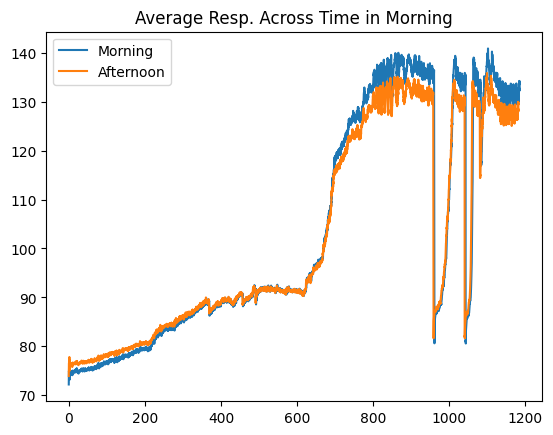

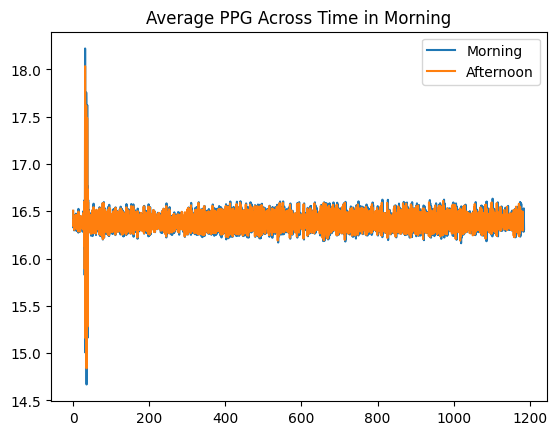

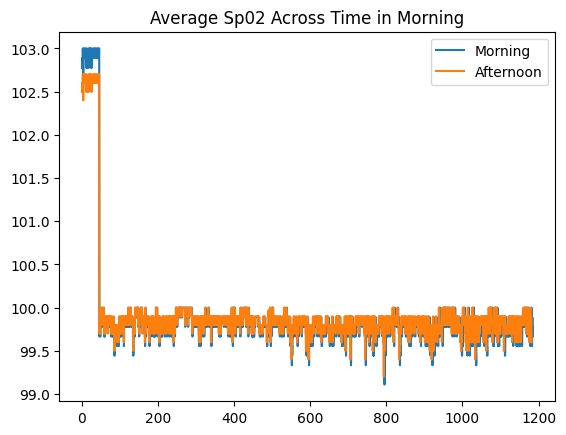

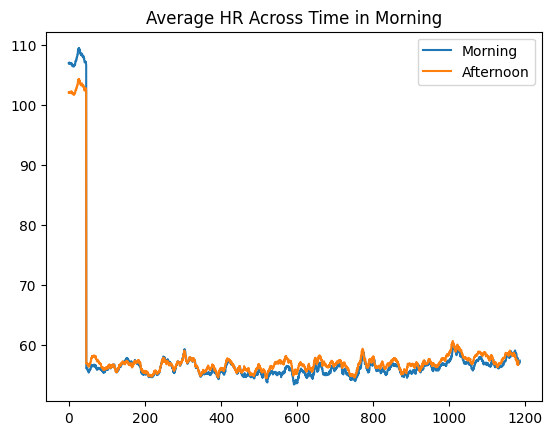

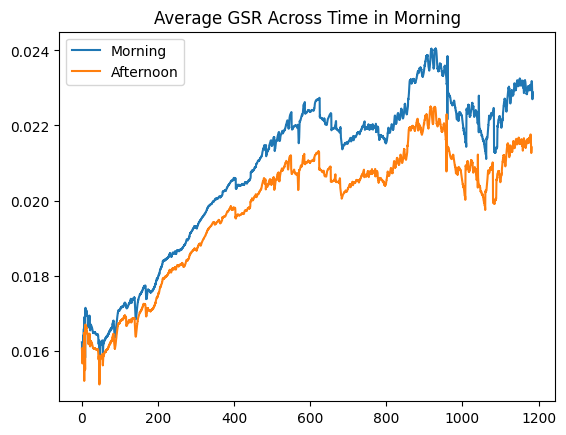

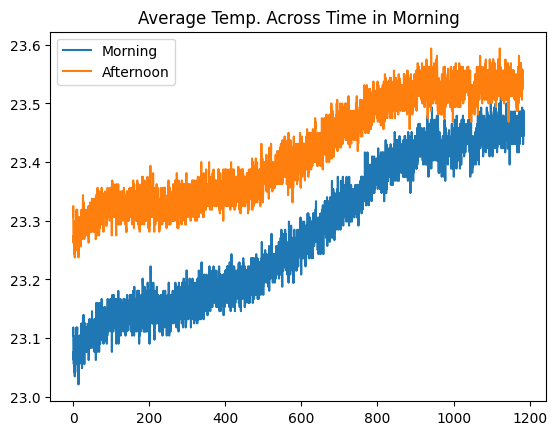

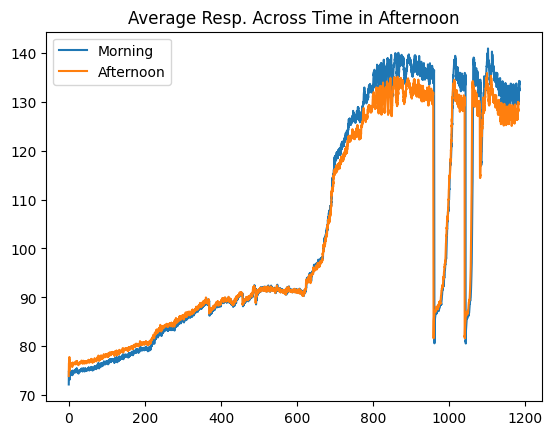

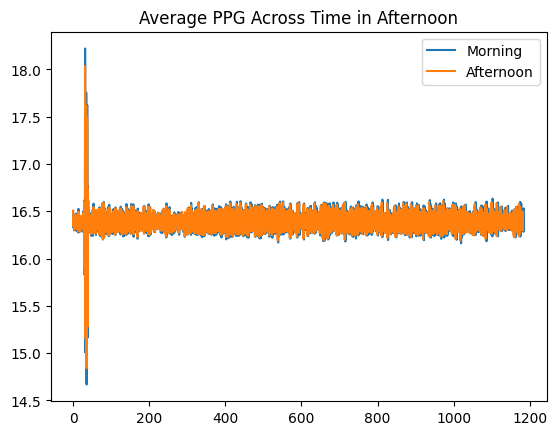

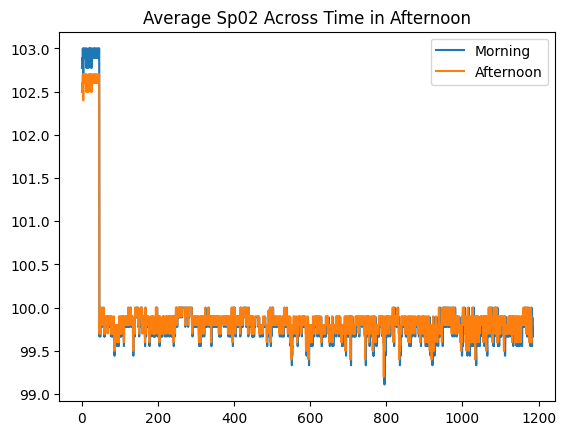

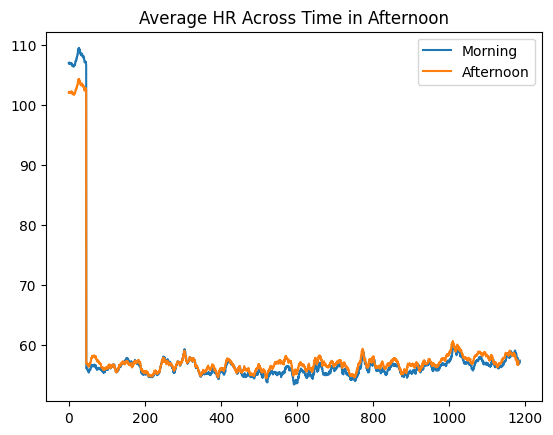

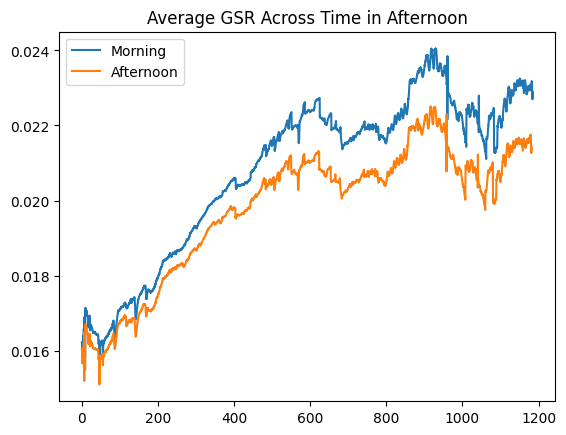

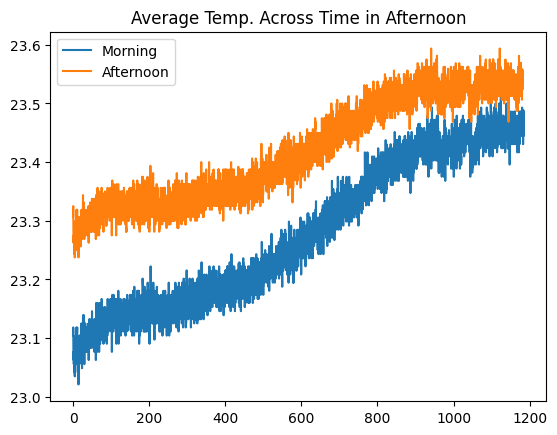

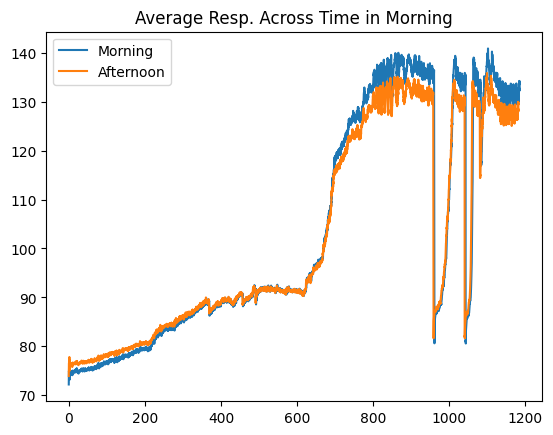

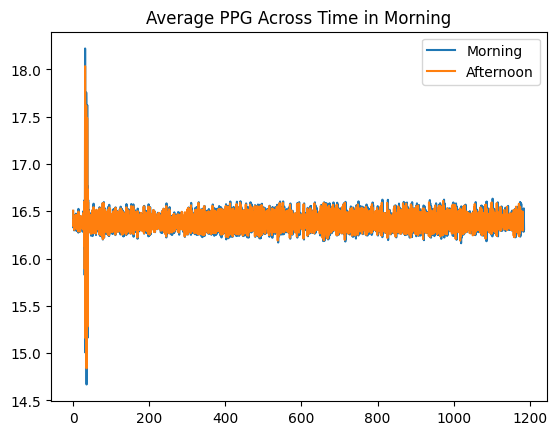

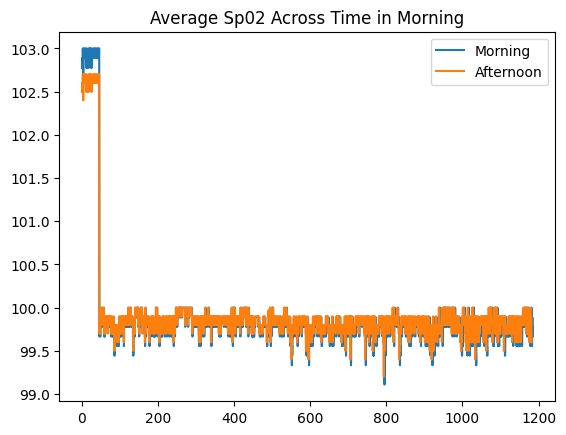

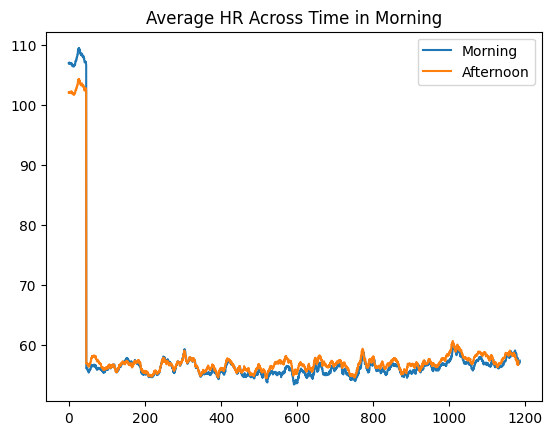

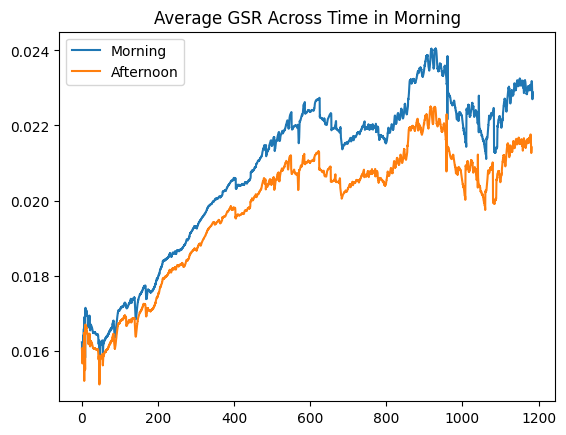

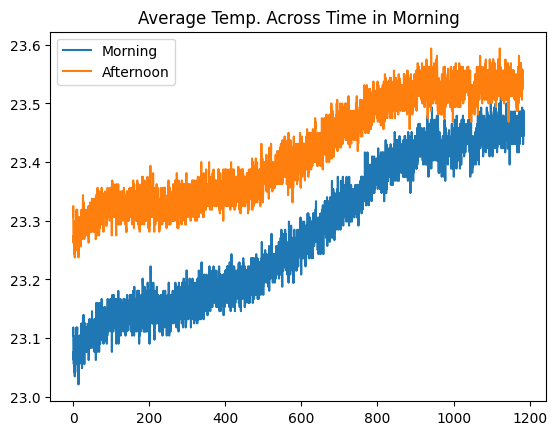

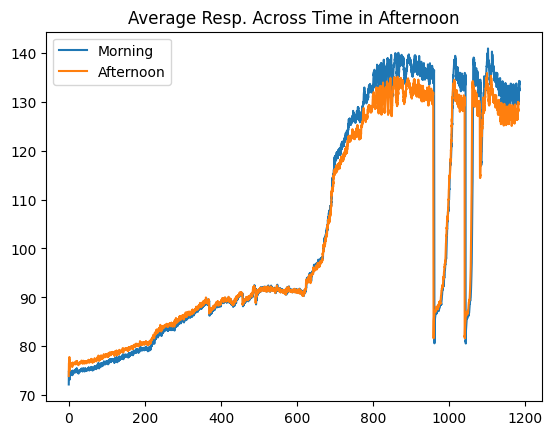

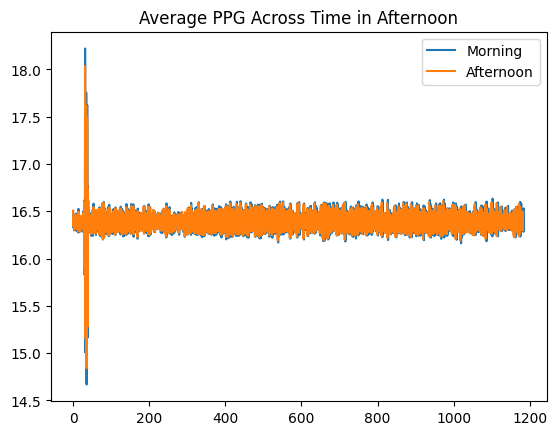

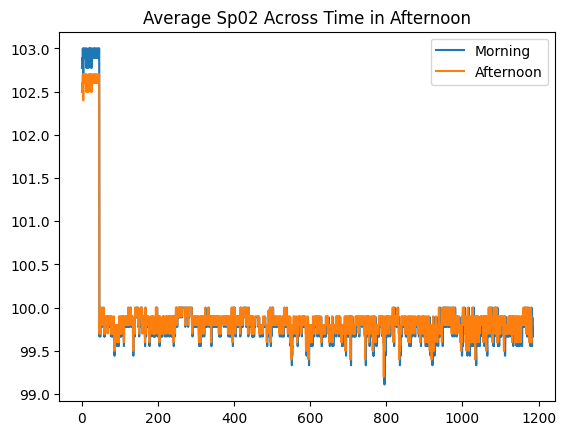

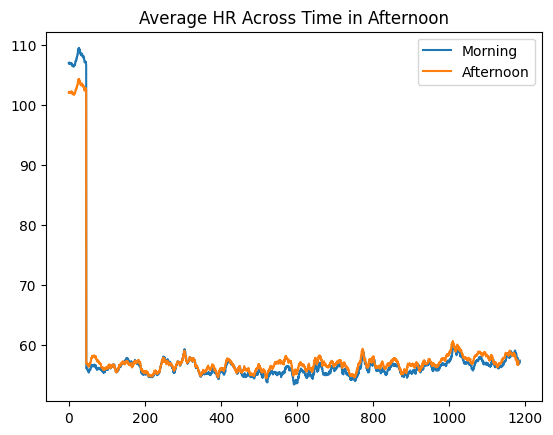

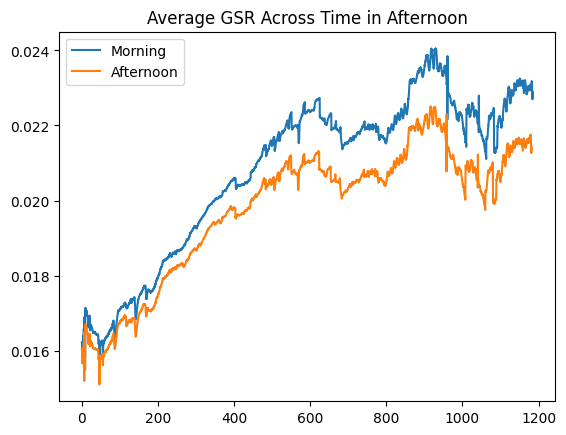

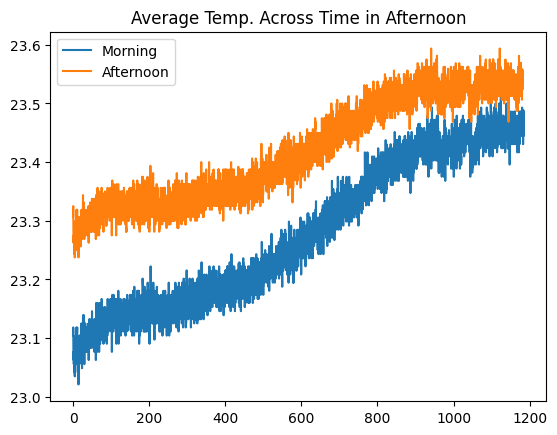

In [54]:
dfs = [morn_df, aft_df]


for df in dfs:
    for tod in ['Morning', 'Afternoon']:
        for ch in ch_names:
            plt.figure()
            plt.title(f'Average {ch} Across Time in {tod}')
            plt.plot(morn_df['time'], morn_df[ch], label='Morning')
            plt.plot(aft_df['time'], aft_df[ch], label='Afternoon')
            plt.legend()
            plt.show()

In [55]:
all_df = pd.concat(sub_frames, ignore_index=True, axis=0)


morn_df['Time of Day'] = 'Morning'
aft_df['Time of Day'] = 'Afternoon'

all_means = pd. concat((morn_df, aft_df), ignore_index=True, axis=0)

# Check for NaN values in 'all_df'
has_nan = all_df.isna().any().any()
has_nan = all_means.isna().any().any()

if has_nan:
    print("There are NaN values in 'all_df'.")
else:
    print("There are no NaN values in 'all_df'.")

display(all_means)

There are no NaN values in 'all_df'.


,time,Resp.,PPG,Sp02,HR,GSR,Temp.,Time of Day
0,0.000000,72.175904,16.503549,102.777778,107.000000,0.016224,23.104167,Morning
1,0.196600,73.928615,16.372471,102.777778,107.000000,0.016202,23.104167,Morning
2,0.393200,74.923764,16.328434,102.777778,107.000000,0.016094,23.104167,Morning
3,0.589800,74.808711,16.378757,102.858137,107.000000,0.015960,23.118056,Morning
4,0.830089,75.779947,16.419009,102.888889,106.888889,0.016010,23.076389,Morning
...,...,...,...,...,...,...,...,...
11583,1180.956540,129.363569,16.295472,99.700000,56.600000,0.021288,23.531250,Afternoon
11584,1181.153140,129.874219,16.497171,99.700000,57.000000,0.021298,23.556250,Afternoon
11585,1181.349740,129.597990,16.428300,99.700000,57.000000,0.021337,23.543750,Afternoon
11586,1181.546340,128.046292,16.387534,99.700000,57.200000,0.021388,23.543750,Afternoon


In [56]:
descr_dfm = pd.DataFrame()
for ch in ch_names:
    descr_dfm[ch] = morn_df[ch].describe()

descr_dfa = pd.DataFrame()
for ch in ch_names:
    descr_dfa[ch] = aft_df[ch].describe()

descr_dfm = descr_dfm.T.drop(columns=['count'])
descr_dfa = descr_dfa.T.drop(columns=['count'])
display(descr_dfm)
display(descr_dfa)

,mean,std,min,25%,50%,75%,max
Resp.,103.112583,23.172105,72.175904,85.038785,91.426989,131.481470,140.910891
PPG,16.384330,0.106950,14.668333,16.326992,16.377778,16.436800,18.222111
Sp02,99.919082,0.610603,99.111111,99.777778,99.777778,99.888889,103.000000
HR,58.104931,9.990415,53.333333,55.333333,56.111111,56.888889,109.444444
GSR,0.020803,0.002154,0.015410,0.019273,0.021686,0.022315,0.024051
Temp.,23.277712,0.124825,23.020833,23.166667,23.256944,23.409722,23.527778


,mean,std,min,25%,50%,75%,max
Resp.,101.904548,20.843034,73.901302,85.615308,91.398530,127.389983,135.895755
PPG,16.384258,0.096397,14.839500,16.332589,16.378029,16.431844,18.035200
Sp02,99.926432,0.549703,99.200000,99.800000,99.800000,99.900000,102.700000
HR,58.516443,8.935640,54.400000,56.100000,56.800000,57.400000,104.300000
GSR,0.019789,0.001766,0.015100,0.018685,0.020495,0.020965,0.022507
Temp.,23.419670,0.088090,23.237500,23.337500,23.406250,23.512500,23.593750


In [57]:
icc_resp = pg.intraclass_corr(data=all_means, targets='Time of Day', raters='time', ratings='GSR',nan_policy='omit')

icc_resp.set_index('Type')

print(icc_resp.n)

display(icc_resp)

AssertionError: Data must have at least 5 non-missing values.

In [ ]:
from itertools import compress
from mne import Epochs, events_from_annotations
import mne 
import mne.stats as ms
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf, ccovf

In [ ]:
stats_df = pd.DataFrame()
lags = [1, 2]


stats_df['CCF'] = [ccf(morn_df['GSR'], aft_df['GSR'])]
stats_df['CCOVF'] = [ccovf(morn_df['GSR'], aft_df['GSR'])]

print(stats_df['CCF'])
print(len(stats_df['CCF']))
print(stats_df['CCOVF'])
print(len(stats_df['CCOVF']))

display(stats_df)

0    [0.9964665078776359, 0.995892479134607, 0.9953...
Name: CCF, dtype: object
1
0    [3.7887189691459373e-06, 3.7865364235507215e-0...
Name: CCOVF, dtype: object
1


,CCF,CCOVF
0,"[0.9964665078776359, 0.995892479134607, 0.9953...","[3.7887189691459373e-06, 3.7865364235507215e-0..."


In [ ]:
ms.f_oneway(morn_df['GSR'], aft_df['GSR'])

768.9633811806651

In [ ]:
def normalize(raw_haemo,epochs):
    hold_data_all = epochs["1.0"].average() # take the average of breath holds for this subject
    hold_data_all = hold_data_all.get_data() # get the data

    max_during_hold = np.max(hold_data_all) # this should be a 1 x num_channels array

    z = raw_haemo.get_data() # extract (only long channel) data from oxy and deoxy-hemoglobin concentration matrix
    z = np.transpose(z) / max_during_hold # Divide all traces in each channel by the maximum change in concentration during the breath hold.

    # We are now in arbitrary units (deltaHb / deltaHb)
    raw_haemo._data= np.transpose(z) # replace the data in raw_haemo

    return raw_haemo, epochs

In [ ]:
def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path, verbose=False)

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(1)
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od = short_channel_regression(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od)
    
    ## FILTERS OUT HEART RATE
    raw_haemo = raw_haemo.filter(None, 0.4,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)
    raw_haemo.annotations.delete(raw_haemo.annotations.description == '15')
    
    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)

    # raw_haemo = get_long_channels(raw_haemo, min_dist=0.01)

    # Pick data channels that are actually informative
    roi_channels = mne.pick_channels(raw_haemo.info['ch_names'], include=['Left_PT','Right_PT'])
    raw_haemo = raw_haemo.copy().pick_channels(roi_channels)

    # Extract events but ignore those with
    events, event_dict = events_from_annotations(raw_haemo, verbose=False,
                                                 regexp='^(?![Ends]).*$')

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-5, tmax=30,
                    reject=dict(hbo=100e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=1,
                    preload=True, verbose=False,event_repeated='merge')
    
    raw_haemo, epochs = normalize(raw_haemo,epochs)

    return raw_haemo, epochs

In [ ]:
haemo_morn = []
haemo_aft = []

eps_morn = []
eps_aft = []

haemo_frames = {}
eps_frames = {}


for sub in range(1,5):
    subject_id = "%02d" % sub
    bids_path = BIDSPath(
        subject="%02d" % sub,
        task="task",
        # session='01',
        datatype="nirs",
        suffix='nirs',
        root=r"C:\Users\dalto\Downloads\project\sourcedata_lm",
        extension=".snirf"
    )

    # Read source data
    fname = str(bids_path.directory)
    print(fname)
    raw = mne.io.read_raw_snirf(bids_path, preload=False)
    raw.info["line_freq"] = 50  # specify line frequency as required by BIDS
    events, event_id = mne.events_from_annotations(raw)
    raw_haemo, epochs = individual_analysis(bids_path)
    ch_names = raw_haemo.ch_names
    epochs = epochs[["1.0", "2.0"]]
    cov = mne.compute_covariance(epochs, tmax=0.0)
    # print(f'cov: {cov}')


    haemo_frames[sub] = pd.DataFrame(raw_haemo.get_data()).T
    eps_frames[sub] = epochs.get_data()
    # print(eps_frames[sub].shape)
    
    eps_frames[sub] = pd.DataFrame(np.concatenate(eps_frames[sub], axis=1)).T

    # print(eps_frames[sub].shape)

    # display(eps_frames[sub])

    haemo_frames[sub].columns = ch_names
    haemo_frames[sub].insert(0, 'Sub', sub)
    haemo_frames[sub].insert(1, 'Time', raw_haemo.times)

    eps_frames[sub].columns = ch_names
    eps_frames[sub].insert(0, 'Sub', sub)
    # print(epochs.times)
    # eps_frames[sub].insert(1, 'Time', raw_haemo.times)


    if sub % 2 == 1:
        # haemo_frames[sub].append(raw_haemo.get_data())
        # eps_morn.append(epochs.get_data())
        haemo_frames[sub].insert(2, 'Time of Day', 'Morning')
    else:
        haemo_frames[sub].insert(2, 'Time of Day', 'Afternoon')
        

    display(haemo_frames[sub].head())

    

# haemo_arr = np.array(haemo_morn[0])
# haemo_aft = np.array(haemo_aft[0])

# haemo_aft = np.array(haemo_aft)

# hmorn_df = pd.DataFrame(haemo_morn).T
# haft_df = pd.DataFrame(haemo_aft).T


# haft_df.columns = ch_names

C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\nirs
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-01\nirs\sub-01_task-task_nirs.snirf
Used Annotations descriptions: ['1.0', '15.0', '2.0']
Reading 0 ... 5829  =      0.000 ...  1145.981 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
Computing rank from data with rank=None
    Using tolerance 1.3e-13 (2.2e-16 eps * 46 dim * 13  max singular value)
    Estimated rank (hbo): 46
    HBO: rank 46 computed from 46 data channels with 0 projectors
    Using tolerance 5.1e-14 (2.2e-16 eps * 46 dim * 5  max singular value)
    Estimated rank (hbr): 46
    HBR: rank 46 computed from 46 data channels with 0 projectors
Reducing data rank from 92 -> 92
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 234
[done]


C:\Users\dalto\AppData\Local\Temp\ipykernel_22248\2754687330.py:32: RuntimeWarning: Too few samples (required : 465 got : 234), covariance estimate may be unreliable
  cov = mne.compute_covariance(epochs, tmax=0.0)


,Sub,Time,Time of Day,S1_D1 hbo,S1_D1 hbr,S2_D1 hbo,S2_D1 hbr,S3_D1 hbo,S3_D1 hbr,S3_D2 hbo,...,S15_D12 hbo,S15_D12 hbr,S15_D14 hbo,S15_D14 hbr,S16_D13 hbo,S16_D13 hbr,S16_D14 hbo,S16_D14 hbr,S16_D22 hbo,S16_D22 hbr
0,1,0.0,Morning,-2.519364,1.341744,-11.243175,5.675317,2.490603,-0.757349,-9.116206,...,0.728434,-0.485226,1.064206,-0.443978,-1.398065,0.353386,1.182103,-0.332401,-1.645955,0.312353
1,1,1.0,Morning,-2.128965,1.133828,-11.739999,5.926103,2.504831,-0.761676,-8.202733,...,0.684412,-0.455902,1.334644,-0.556802,-1.395761,0.352804,0.947408,-0.266406,-1.928378,0.365948
2,1,2.0,Morning,-2.218458,1.181489,-11.356453,5.732497,2.411229,-0.733213,-8.456272,...,0.808622,-0.538641,1.345808,-0.561460,-1.427182,0.360746,1.228295,-0.345390,-1.896675,0.359932
3,1,3.0,Morning,-2.243131,1.194629,-11.799690,5.956234,2.287299,-0.695528,-8.294086,...,0.756891,-0.504182,1.446536,-0.603483,-1.189681,0.300713,1.218694,-0.342690,-1.759968,0.333989
4,1,4.0,Morning,-2.495494,1.329031,-12.050533,6.082854,2.108306,-0.641100,-8.803525,...,0.747430,-0.497879,1.498841,-0.625304,-1.198581,0.302963,1.340736,-0.377008,-1.584097,0.300614


C:\Users\dalto\Downloads\project\sourcedata_lm\sub-02\nirs
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-02\nirs\sub-02_task-task_nirs.snirf
Used Annotations descriptions: ['1.0', '15.0', '2.0']
Reading 0 ... 6250  =      0.000 ...  1228.750 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
Computing rank from data with rank=None
    Using tolerance 4.4e-14 (2.2e-16 eps * 46 dim * 4.3  max singular value)
    Estimated rank (hbo): 45
    HBO: rank 45 computed from 46 data channels with 0 projectors
    Using tolerance 2.2e-14 (2.2e-16 eps * 46 dim * 2.2  max singular value)
    Estimated rank (hbr): 45
    HBR: rank 45 computed from 46 data channels with 0 projectors
    Setting small HBO eigenvalues to zero (without PCA)
    Setting small HBR eigenvalues to zero (without PCA)
Reducing data rank from 92 -> 90
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 240
[done]


C:\Users\dalto\AppData\Local\Temp\ipykernel_22248\2754687330.py:32: RuntimeWarning: Too few samples (required : 465 got : 240), covariance estimate may be unreliable
  cov = mne.compute_covariance(epochs, tmax=0.0)


,Sub,Time,Time of Day,S1_D1 hbo,S1_D1 hbr,S2_D1 hbo,S2_D1 hbr,S3_D1 hbo,S3_D1 hbr,S3_D2 hbo,...,S15_D12 hbo,S15_D12 hbr,S15_D14 hbo,S15_D14 hbr,S16_D13 hbo,S16_D13 hbr,S16_D14 hbo,S16_D14 hbr,S16_D22 hbo,S16_D22 hbr
0,2,0.0,Afternoon,-0.739060,0.430421,-13.782902,8.764716,-0.900820,0.488438,0.787452,...,-0.699627,0.381432,-0.923514,0.341361,0.628928,-0.192493,0.352028,-0.119365,-1.825628,1.161435
1,2,1.0,Afternoon,-0.759028,0.442050,-13.043990,8.294833,-0.972796,0.527464,0.651428,...,-0.088460,0.048228,-0.705396,0.260738,0.901577,-0.275941,0.308664,-0.104661,-1.305391,0.830469
2,2,2.0,Afternoon,-0.752303,0.438133,-12.589480,8.005805,-0.781121,0.423535,1.325878,...,-0.602192,0.328312,-0.468461,0.173159,0.951188,-0.291125,0.559477,-0.189706,-1.261840,0.802762
3,2,3.0,Afternoon,-0.613283,0.357170,-12.295464,7.818836,-0.545309,0.295674,0.673691,...,-0.562742,0.306804,-0.333053,0.123107,1.054754,-0.322823,0.580237,-0.196745,-1.213091,0.771750
4,2,4.0,Afternoon,-0.454800,0.264871,-11.720000,7.452892,-0.327637,0.177650,0.885526,...,0.074612,-0.040678,-0.289416,0.106978,1.038877,-0.317963,0.478508,-0.162251,-1.295936,0.824454


C:\Users\dalto\Downloads\project\sourcedata_lm\sub-03\nirs
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-03\nirs\sub-03_task-task_nirs.snirf
Used Annotations descriptions: ['1.0', '15.0', '2.0']
Reading 0 ... 6022  =      0.000 ...  1183.925 secs...


C:\Users\dalto\AppData\Local\Temp\ipykernel_22248\3849203197.py:9: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


Computing rank from data with rank=None
    Using tolerance 7.1e-14 (2.2e-16 eps * 46 dim * 6.9  max singular value)
    Estimated rank (hbo): 46
    HBO: rank 46 computed from 46 data channels with 0 projectors
    Using tolerance 3.5e-14 (2.2e-16 eps * 46 dim * 3.5  max singular value)
    Estimated rank (hbr): 46
    HBR: rank 46 computed from 46 data channels with 0 projectors
Reducing data rank from 92 -> 92
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 240
[done]


C:\Users\dalto\AppData\Local\Temp\ipykernel_22248\2754687330.py:32: RuntimeWarning: Too few samples (required : 465 got : 240), covariance estimate may be unreliable
  cov = mne.compute_covariance(epochs, tmax=0.0)


,Sub,Time,Time of Day,S1_D1 hbo,S1_D1 hbr,S2_D1 hbo,S2_D1 hbr,S3_D1 hbo,S3_D1 hbr,S3_D2 hbo,...,S15_D12 hbo,S15_D12 hbr,S15_D14 hbo,S15_D14 hbr,S16_D13 hbo,S16_D13 hbr,S16_D14 hbo,S16_D14 hbr,S16_D22 hbo,S16_D22 hbr
0,3,0.0,Morning,-1.376071,0.637094,-4.696575,2.504661,-2.648877,0.802113,-3.646700,...,7.963516,-2.400867,5.818849,-1.269385,-3.502023,1.042185,-3.519996,0.545435,4.072172,-5.069957
1,3,1.0,Morning,-1.768929,0.818979,-4.151498,2.213974,-2.690633,0.814757,-3.378725,...,7.949661,-2.396689,6.668762,-1.454794,-1.320576,0.392997,-3.982888,0.617162,5.005781,-6.232325
2,3,2.0,Morning,-1.492477,0.690988,-4.225610,2.253498,-2.424046,0.734031,-3.325548,...,7.944264,-2.395062,6.634613,-1.447344,-0.443635,0.132024,-3.764392,0.583305,5.407859,-6.732922
3,3,3.0,Morning,-1.262557,0.584539,-4.163297,2.220267,-2.154186,0.652314,-2.506650,...,8.652608,-2.608616,7.161976,-1.562389,-2.337409,0.695602,-3.778372,0.585471,5.657012,-7.043123
4,3,4.0,Morning,-1.448788,0.670761,-3.814748,2.034387,-2.120251,0.642038,-3.166373,...,9.626040,-2.902090,7.388249,-1.611750,-0.541088,0.161025,-3.321926,0.514744,6.149892,-7.656772


C:\Users\dalto\Downloads\project\sourcedata_lm\sub-04\nirs
Loading C:\Users\dalto\Downloads\project\sourcedata_lm\sub-04\nirs\sub-04_task-task_nirs.snirf
Used Annotations descriptions: ['1.0', '15.0', '2.0']
Reading 0 ... 6124  =      0.000 ...  1203.978 secs...
Interpolating bad channels
    Automatic origin fit: head of radius 90.8 mm
Computing rank from data with rank=None
    Using tolerance 5.2e-14 (2.2e-16 eps * 46 dim * 5.1  max singular value)
    Estimated rank (hbo): 44
    HBO: rank 44 computed from 46 data channels with 0 projectors
    Using tolerance 2.2e-14 (2.2e-16 eps * 46 dim * 2.2  max singular value)
    Estimated rank (hbr): 44
    HBR: rank 44 computed from 46 data channels with 0 projectors
    Setting small HBO eigenvalues to zero (without PCA)
    Setting small HBR eigenvalues to zero (without PCA)
Reducing data rank from 92 -> 88
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 240
[done]


C:\Users\dalto\AppData\Local\Temp\ipykernel_22248\2754687330.py:32: RuntimeWarning: Too few samples (required : 465 got : 240), covariance estimate may be unreliable
  cov = mne.compute_covariance(epochs, tmax=0.0)


,Sub,Time,Time of Day,S1_D1 hbo,S1_D1 hbr,S2_D1 hbo,S2_D1 hbr,S3_D1 hbo,S3_D1 hbr,S3_D2 hbo,...,S15_D12 hbo,S15_D12 hbr,S15_D14 hbo,S15_D14 hbr,S16_D13 hbo,S16_D13 hbr,S16_D14 hbo,S16_D14 hbr,S16_D22 hbo,S16_D22 hbr
0,4,0.0,Afternoon,-1.400875,0.418439,3.843826,-1.488587,-2.902423,1.035031,-3.913023,...,1.142969,-0.405637,-0.478793,0.085413,-3.547019,0.537639,-1.506584,0.563411,-0.225570,0.204390
1,4,1.0,Afternoon,-1.041988,0.311240,4.026929,-1.559496,-2.270458,0.809667,-2.443801,...,1.330359,-0.472141,-0.590129,0.105274,-3.298712,0.500002,-1.938543,0.724949,-0.396431,0.359208
2,4,2.0,Afternoon,-0.757562,0.226283,4.124925,-1.597447,-1.880441,0.670583,-1.716498,...,1.873897,-0.665041,-0.189779,0.033855,-2.943904,0.446222,-2.588111,0.967866,-0.433156,0.392484
3,4,3.0,Afternoon,-0.843852,0.252057,3.509991,-1.359303,-2.020494,0.720527,-1.473365,...,1.496569,-0.531129,-0.276529,0.049330,-3.119564,0.472847,-2.728243,1.020270,-0.410452,0.371912
4,4,4.0,Afternoon,-1.509454,0.450872,3.576914,-1.385220,-3.046872,1.086543,-2.381942,...,0.926734,-0.328896,-0.726454,0.129593,-3.762368,0.570280,-2.484147,0.928986,-0.453143,0.410595


In [ ]:
display(haemo_frames[1])

,Sub,Time,Time of Day,S1_D1 hbo,S1_D1 hbr,S2_D1 hbo,S2_D1 hbr,S3_D1 hbo,S3_D1 hbr,S3_D2 hbo,...,S15_D12 hbo,S15_D12 hbr,S15_D14 hbo,S15_D14 hbr,S16_D13 hbo,S16_D13 hbr,S16_D14 hbo,S16_D14 hbr,S16_D22 hbo,S16_D22 hbr
0,1,0.0,Morning,-2.519364,1.341744,-11.243175,5.675317,2.490603,-0.757349,-9.116206,...,0.728434,-0.485226,1.064206,-0.443978,-1.398065,0.353386,1.182103,-0.332401,-1.645955,0.312353
1,1,1.0,Morning,-2.128965,1.133828,-11.739999,5.926103,2.504831,-0.761676,-8.202733,...,0.684412,-0.455902,1.334644,-0.556802,-1.395761,0.352804,0.947408,-0.266406,-1.928378,0.365948
2,1,2.0,Morning,-2.218458,1.181489,-11.356453,5.732497,2.411229,-0.733213,-8.456272,...,0.808622,-0.538641,1.345808,-0.561460,-1.427182,0.360746,1.228295,-0.345390,-1.896675,0.359932
3,1,3.0,Morning,-2.243131,1.194629,-11.799690,5.956234,2.287299,-0.695528,-8.294086,...,0.756891,-0.504182,1.446536,-0.603483,-1.189681,0.300713,1.218694,-0.342690,-1.759968,0.333989
4,1,4.0,Morning,-2.495494,1.329031,-12.050533,6.082854,2.108306,-0.641100,-8.803525,...,0.747430,-0.497879,1.498841,-0.625304,-1.198581,0.302963,1.340736,-0.377008,-1.584097,0.300614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,1,1141.0,Morning,-1.064626,0.566990,-11.324249,5.716241,2.171241,-0.660237,-5.977910,...,0.498373,-0.331977,0.691978,-0.288687,-0.897033,0.226741,0.835886,-0.235047,-2.115693,0.401495
1142,1,1142.0,Morning,-1.493796,0.795554,-10.910809,5.507545,2.245360,-0.682775,-7.206805,...,0.670502,-0.446636,0.790957,-0.329981,-0.775613,0.196050,1.003954,-0.282307,-1.658260,0.314688
1143,1,1143.0,Morning,-1.956270,1.041855,-10.685699,5.393915,2.327668,-0.707804,-8.402604,...,0.839263,-0.559052,0.863789,-0.360365,-0.581833,0.147069,1.076788,-0.302787,-1.206124,0.228886
1144,1,1144.0,Morning,-2.155633,1.148030,-10.691220,5.396702,2.251338,-0.684593,-8.567065,...,0.698324,-0.465169,1.101685,-0.459614,-0.565641,0.142976,1.180905,-0.332065,-1.439879,0.273246


In [ ]:
lowest_idx = 100000
# dfs = [hmorn_df, haft_df]

for sub in haemo_frames:
    print(f'\nsub: {sub}')
    print(f'len: {len(haemo_frames[sub])}')
    if len(haemo_frames[sub]) < lowest_idx:
        lowest_idx = len(haemo_frames[sub])
        print(f'lowest_idx: {lowest_idx}')

print(lowest_idx)

for sub in haemo_frames:
    resampled_df = haemo_frames[sub].sample(n=lowest_idx, random_state=42)
    resampled_df.sort_index(inplace=True)
    # print(f'\nresampled len: {len(resampled_df)}')

    haemo_frames[sub] = resampled_df
    # print('df.tail:\n')

    haemo_frames[sub].reset_index(drop=True, inplace=True)
    # print(f'length of df: {len(df)}\n')

    # display(df.tail())
    # print('sampled')


# display(hmorn_df.tail())
# display(haft_df.tail())

display(haemo_frames[1].head())

print(len(haemo_frames[1]))
print(len(haemo_frames[2]))


sub: 1
len: 1146
lowest_idx: 1146

sub: 2
len: 1229

sub: 3
len: 1184

sub: 4
len: 1204
1146


,Sub,Time,Time of Day,S1_D1 hbo,S1_D1 hbr,S2_D1 hbo,S2_D1 hbr,S3_D1 hbo,S3_D1 hbr,S3_D2 hbo,...,S15_D12 hbo,S15_D12 hbr,S15_D14 hbo,S15_D14 hbr,S16_D13 hbo,S16_D13 hbr,S16_D14 hbo,S16_D14 hbr,S16_D22 hbo,S16_D22 hbr
0,1,0.0,Morning,-2.519364,1.341744,-11.243175,5.675317,2.490603,-0.757349,-9.116206,...,0.728434,-0.485226,1.064206,-0.443978,-1.398065,0.353386,1.182103,-0.332401,-1.645955,0.312353
1,1,1.0,Morning,-2.128965,1.133828,-11.739999,5.926103,2.504831,-0.761676,-8.202733,...,0.684412,-0.455902,1.334644,-0.556802,-1.395761,0.352804,0.947408,-0.266406,-1.928378,0.365948
2,1,2.0,Morning,-2.218458,1.181489,-11.356453,5.732497,2.411229,-0.733213,-8.456272,...,0.808622,-0.538641,1.345808,-0.561460,-1.427182,0.360746,1.228295,-0.345390,-1.896675,0.359932
3,1,3.0,Morning,-2.243131,1.194629,-11.799690,5.956234,2.287299,-0.695528,-8.294086,...,0.756891,-0.504182,1.446536,-0.603483,-1.189681,0.300713,1.218694,-0.342690,-1.759968,0.333989
4,1,4.0,Morning,-2.495494,1.329031,-12.050533,6.082854,2.108306,-0.641100,-8.803525,...,0.747430,-0.497879,1.498841,-0.625304,-1.198581,0.302963,1.340736,-0.377008,-1.584097,0.300614


1146
1146


In [ ]:
all_haemo = pd.concat(haemo_frames, ignore_index=True, axis=0)
display(all_haemo)

,Sub,Time,Time of Day,S1_D1 hbo,S1_D1 hbr,S2_D1 hbo,S2_D1 hbr,S3_D1 hbo,S3_D1 hbr,S3_D2 hbo,...,S15_D12 hbo,S15_D12 hbr,S15_D14 hbo,S15_D14 hbr,S16_D13 hbo,S16_D13 hbr,S16_D14 hbo,S16_D14 hbr,S16_D22 hbo,S16_D22 hbr
0,1,0.0,Morning,-2.519364,1.341744,-11.243175,5.675317,2.490603,-0.757349,-9.116206,...,0.728434,-0.485226,1.064206,-0.443978,-1.398065,0.353386,1.182103,-0.332401,-1.645955,0.312353
1,1,1.0,Morning,-2.128965,1.133828,-11.739999,5.926103,2.504831,-0.761676,-8.202733,...,0.684412,-0.455902,1.334644,-0.556802,-1.395761,0.352804,0.947408,-0.266406,-1.928378,0.365948
2,1,2.0,Morning,-2.218458,1.181489,-11.356453,5.732497,2.411229,-0.733213,-8.456272,...,0.808622,-0.538641,1.345808,-0.561460,-1.427182,0.360746,1.228295,-0.345390,-1.896675,0.359932
3,1,3.0,Morning,-2.243131,1.194629,-11.799690,5.956234,2.287299,-0.695528,-8.294086,...,0.756891,-0.504182,1.446536,-0.603483,-1.189681,0.300713,1.218694,-0.342690,-1.759968,0.333989
4,1,4.0,Morning,-2.495494,1.329031,-12.050533,6.082854,2.108306,-0.641100,-8.803525,...,0.747430,-0.497879,1.498841,-0.625304,-1.198581,0.302963,1.340736,-0.377008,-1.584097,0.300614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,4,1199.0,Afternoon,0.176137,-0.052612,3.424909,-1.326354,-0.985157,0.351316,-2.592691,...,0.916771,-0.325360,0.005534,-0.000987,-3.180726,0.482118,-2.928426,1.095132,-0.526613,0.477166
4580,4,1200.0,Afternoon,0.165151,-0.049330,3.384772,-1.310810,-0.860367,0.306815,-2.533575,...,1.644559,-0.583650,0.205701,-0.036695,-2.808851,0.425751,-2.815135,1.052765,-0.405553,0.367473
4581,4,1201.0,Afternoon,-0.438078,0.130853,3.415945,-1.322883,-1.748336,0.623473,-3.461177,...,1.143915,-0.405973,0.088480,-0.015784,-2.977685,0.451342,-2.456759,0.918744,-0.391989,0.355182
4582,4,1202.0,Afternoon,-0.899967,0.268819,3.395438,-1.314941,-3.378803,1.204913,-3.361508,...,0.855477,-0.303607,-0.372386,0.066431,-3.653586,0.553792,-2.396398,0.896171,-0.401102,0.363440


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
# Import necessary libraries
import pandas as pd

# Calculate descriptive statistics by time of day
descriptive_stats = all_haemo.groupby("Time of Day").agg(["mean", "std", "median"])
display(descriptive_stats)

Sub                         Time                    S1_D1 hbo  \
            mean       std median        mean         std median      mean   
Time of Day                                                                  
Afternoon    3.0  1.000218    3.0  606.980803  350.400436  607.0  0.003323   
Morning      2.0  1.000218    2.0  581.317190  336.255047  581.0 -0.000694   

                                S1_D1 hbr  ... S16_D14 hbo S16_D14 hbr  \
                  std    median      mean  ...      median        mean   
Time of Day                                ...                           
Afternoon    1.611771 -0.219300 -0.000933  ...     0.06375   -0.002235   
Morning      2.467169 -0.294751  0.000321  ...     0.00731   -0.000344   

                                S16_D22 hbo                     S16_D22 hbr  \
                  std    median        mean       std    median        mean   
Time of Day                                                                   
Afternoon    0.695101 -0.022711    0.004116  0.933836  0.112065   -0.002636   
Morning      0.390377 -0.001330   -0.021827  3.549957  0.169477    0.027175   

                                 
                  std    median  
Time of Day                      
Afternoon    0.682831 -0.080231  
Morning      4.251581 -0.041351  

[2 rows x 282 columns]

In [ ]:
# for frame in frames:
    # frame.drop(columns=['Time of Day'], inplace=True)

# aft_ccf = mne.Covariance(data=haemo_frames[1], names=haemo_frames[1].columns[2:], bads=None, projs=[], method='auto', verbose=None, nfree=45)
# print(len(aft_ccf))
# print(aft_ccf)

# Assuming your data is in a DataFrame called 'df'
formula = 'measurement ~ subject'
model = ols(formula, data=all_haemo).fit()
print(model.summary())
# icc = sm.stats.anova_lm(model)['mean_sq']['subject'] / (sm.stats.anova_lm(model)['mean_sq']['subject'] + sm.stats.anova_lm(model)['mean_sq']['Residual'])

print(f'ICC: {icc}')

PatsyError: Error evaluating factor: NameError: name 'measurement' is not defined
    measurement ~ subject
    ^^^^^^^^^^^